# Task 2: PCY Algorithm for Frequent Items

## Store data in Google Drive

In [34]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, collect_list, array_sort
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
spark = SparkSession.builder.appName('dataframe').getOrCreate()

In [36]:
# Put file in MyDrive/MD/ in google drive
file = "/content/drive/MyDrive/MMDS/baskets.csv"
df = spark.read.csv(file, header=True, inferSchema=True)
df.show()
df.printSchema()

+-------------+----------+--------------------+----+-----+---+-----------+
|Member_number|      Date|     itemDescription|year|month|day|day_of_week|
+-------------+----------+--------------------+----+-----+---+-----------+
|         1249|01/01/2014|        citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|              coffee|2014|    1|  1|          2|
|         1381|01/01/2014|                curd|2014|    1|  1|          2|
|         1381|01/01/2014|                soda|2014|    1|  1|          2|
|         1440|01/01/2014|    other vegetables|2014|    1|  1|          2|
|         1440|01/01/2014|              yogurt|2014|    1|  1|          2|
|         1659|01/01/2014| specialty chocolate|2014|    1|  1|          2|
|         1659|01/01/2014|   frozen vegetables|2014|    1|  1|          2|
|         1789|01/01/2014|      hamburger meat|2014|    1|  1|          2|
|         1789|01/01/2014|             candles|2014|    1|  1|          2|
|         1922|01/01/2014

In [37]:
df.count()

38765

## Identify baskets

In [38]:
from pyspark.sql.functions import col, sum as sum_, count, lower, trim

null_counts = df.select(
    [sum_(col(c).isNull().cast("int")).alias(c) for c in df.columns]
)
null_counts.show()
df = df.dropna()
# Nhóm theo tất cả các cột và đếm số dòng của mỗi nhóm
duplicates = df.groupBy(df.columns)\
               .agg(count("*").alias("count")) \
               .filter("count > 1")

# Hiển thị các dòng trùng lặp
duplicates.show()

df_unique = df.dropDuplicates()
# Use lower() function to convert the column to lowercase
df_unique = df_unique.withColumn(
    "itemDescription", lower(col("itemDescription"))
)

# Use trim() function to trim spaces from column
df_unique = df_unique.withColumn(
    "itemDescription", trim(col("itemDescription"))
)
df_unique.count()

+-------------+----+---------------+----+-----+---+-----------+
|Member_number|Date|itemDescription|year|month|day|day_of_week|
+-------------+----+---------------+----+-----+---+-----------+
|            0|   0|              0|   0|    0|  0|          0|
+-------------+----+---------------+----+-----+---+-----------+

+-------------+----------+----------------+----+-----+---+-----------+-----+
|Member_number|      Date| itemDescription|year|month|day|day_of_week|count|
+-------------+----------+----------------+----+-----+---+-----------+-----+
|         1350|09/03/2014|      whole milk|2014|    3|  9|          6|    2|
|         3621|18/05/2014|other vegetables|2014|    5| 18|          6|    2|
|         4323|26/03/2015|     frankfurter|2015|    3| 26|          3|    2|
|         1031|15/10/2015|other vegetables|2015|   10| 15|          3|    2|
|         3907|25/10/2015|other vegetables|2015|   10| 25|          6|    2|
|         4312|14/12/2015|         sausage|2015|   12| 14|     

38006

In [39]:
df_unique.count()

38006

In [40]:
df_unique.select("Member_number", "Date", "itemDescription")

DataFrame[Member_number: int, Date: string, itemDescription: string]

In [41]:
# Create basket column of list of items bought by member in date (items sorted)
baskets = df_unique.groupBy("Member_number", "Date")\
                   .agg(array_sort(collect_list("itemDescription"))\
                   .alias("Basket"))
baskets.show()


+-------------+----------+--------------------+
|Member_number|      Date|              Basket|
+-------------+----------+--------------------+
|         1000|15/03/2015|[sausage, semi-fi...|
|         1000|24/06/2014|[pastry, salty sn...|
|         1000|24/07/2015|[canned beer, mis...|
|         1000|25/11/2015|[hygiene articles...|
|         1000|27/05/2015|[pickled vegetabl...|
|         1001|02/07/2014|[rolls/buns, saus...|
|         1001|05/02/2015| [curd, frankfurter]|
|         1001|12/12/2014|  [soda, whole milk]|
|         1001|14/04/2015| [beef, white bread]|
|         1001|20/01/2015|[frankfurter, sod...|
|         1002|02/09/2014|[frozen vegetable...|
|         1002|26/04/2014|[butter, whole milk]|
|         1002|26/04/2015|[sugar, tropical ...|
|         1002|30/08/2015|[butter milk, spe...|
|         1003|02/10/2015|[rolls/buns, saus...|
|         1003|15/10/2014|[detergent, root ...|
|         1003|19/01/2014|[dental care, fro...|
|         1003|27/02/2014|        [rolls

In [42]:
baskets.select("Basket") \
       .where(
           (col("Date")=="05/01/2014") & (col("Member_number")==2051)
       ).show()

+--------------------+
|              Basket|
+--------------------+
|[cream cheese, fl...|
+--------------------+



In [43]:
# The total baskets
baskets.count()

14963

In [44]:
item_freq = df_unique.groupBy("itemDescription").count()
item_freq.show()


+------------------+-----+
|   itemDescription|count|
+------------------+-----+
|         beverages|  248|
|pickled vegetables|  134|
|    snack products|   27|
|           vinegar|   51|
|    red/blush wine|  157|
|          cat food|  177|
|            dishes|  135|
|          cake bar|   92|
|   organic sausage|   22|
|           napkins|  331|
|              meat|  252|
| frozen vegetables|  419|
|       frozen fish|  102|
|        white wine|  175|
|             honey|   13|
|       frankfurter|  565|
| canned vegetables|   82|
|           mustard|   92|
|    kitchen towels|   30|
|      canned fruit|   21|
+------------------+-----+
only showing top 20 rows



## PCY Algorithm

In [45]:
import time
import pyspark as spark
from pyspark.sql import DataFrame
from pyspark.sql.functions import explode, col, hash, abs, md5, substring, \
monotonically_increasing_id, posexplode, pmod, desc, concat_ws, conv

print(spark.__version__)


3.5.5


###The hashing function

In [46]:
from abc import ABC, abstractmethod
from pyspark.sql.column import Column

class HashFunction(ABC):
  @abstractmethod
  def __init__(self, num_buckets: int):
    self.num_buckets = num_buckets

  @abstractmethod
  def hash_function(self, item1: Column, item2: Column) -> int:
      pass

In [47]:
from pyspark.sql.functions import xxhash64

class XXHashFunction(HashFunction):
  def __init__(self, num_buckets: int):
    super().__init__(num_buckets)

  def hash_function(self, item1, item2):
    xx = xxhash64(concat_ws("_", item1, item2))
    return pmod(abs(xx), self.num_buckets)



In [48]:
class MurmurHash(HashFunction):
  def __init__(self, num_buckets: int):
    super().__init__(num_buckets)

  def hash_function(self, item1, item2):
    return pmod(hash(item1, item2), self.num_buckets)


In [49]:
class MD5Hash(HashFunction):
  def __init__(self, num_buckets: int):
    super().__init__(num_buckets)

  def hash_function(self, item1, item2):
    md5_hash = md5(concat_ws("_", item1, item2))
    conv_hash = conv(
        substring(md5_hash, 1, 15),
        16, 10
    ).cast("bigint")
    return pmod(conv_hash, self.num_buckets)

In [61]:
class PrimeHash(HashFunction):
  def __init__(self, num_buckets, prime):
    super().__init__(num_buckets)
    self.prime = prime

  def hash_function(self, item1, item2):
    return pmod(hash(item1) * self.prime + hash(item2), self.num_buckets)

###PCY

In [51]:
class PCYParams:
  def __init__(self):
    super().__init__()

    self.min_support = 0.3
    self.min_confidence = 0.5
    self.item_col = "Basket"
    self.num_buckets = 1000
    self.hash_function = None

  # Getter methods
  def get_min_support(self):
    return self.min_support

  def get_min_confidence(self):
    return self.min_confidence

  def get_item_col(self):
    return self.item_col

  def get_num_buckets(self):
    return self.num_buckets

  def get_hash_function(self):
    return self.hash_function

  # Setter methods
  def set_min_support(self, value):
    self.min_support = value

  def set_min_confidence(self, value):
    self.min_confidence = value

  def set_item_col(self, value):
    self.item_col = value

  def set_num_buckets(self, value):
    self.num_buckets = value

  def set_hash_function(self, hash_function: HashFunction):
    self.hash_function = hash_function



In [52]:
class PCYModel(PCYParams):
  def __init__(self):
    super().__init__()
    self.freq_items = None
    self.final_pair_counts_df = None
    self.pairs_hashed_df = None

  def get_frequency_items(self) -> DataFrame:
    return self.freq_items

  def get_frequency_pairs(self) -> DataFrame:
    return self.final_pair_counts_df

  def get_pairs_hashed(self) -> DataFrame:
    return self.pairs_hashed_df

  def _generate_association_rules(self, antecedent: str, consequent: str, \
                                  support: str):
    fp_df = self.final_pair_counts_df.alias("fp")
    fi_df = self.freq_items.alias("fi")

    rule_df = fp_df.join(
        fi_df,
        fp_df[antecedent] == fi_df["items"],
        "inner"
    ).select(
        col(f"fp.{antecedent}").alias("Antecedent"),
        col(f"fp.{consequent}").alias("Consequent"),
        col(f"fp.{support}").alias("PairSupport"),
        col(f"fi.{support}").alias("AnteSupport"),
        (col(f"fp.{support}") / col(f"fi.{support}")).alias("Confidence")
    )
    rule_df = rule_df.filter(col("Confidence") >= self.get_min_confidence())

    return rule_df

  def association_rules(self) -> DataFrame:
    rule1_df = self._generate_association_rules("Item1", "Item2", "Support")
    rule2_df = self._generate_association_rules("Item2", "Item1", "Support")

    # join rule1 and rule2
    ass_rule_df = rule1_df.union(rule2_df)

    return ass_rule_df



In [53]:
class PCY(PCYParams):
  def __init__(self):
    self.freq_items = None
    self.final_pair_counts_df = None
    self.pairs_hashed_df = None


  def _create_model(self, min_support, min_confidence, item_col,
                    num_buckets, hash_function) -> PCYModel:
    model = PCYModel()
    model.set_min_support(min_support)
    model.set_min_confidence(min_confidence)
    model.set_item_col(item_col)
    model.set_num_buckets(num_buckets)
    model.set_hash_function(hash_function)
    return model


  def _compute_support(self, df: DataFrame):
    total_baskets = df.count()
    support = self.get_min_support() * total_baskets
    return support


  def _get_item(self, df: DataFrame) -> DataFrame:
    '''two columns: items, freq'''
    # tach cac item trong basket ra
    items = df.select(
        explode(df[self.get_item_col()]).alias("items")
    )
    item_freq_df = items.groupBy("items").count()
    return item_freq_df


  def create_pairs_item(self, df: DataFrame) -> DataFrame:
    # insert id column
    baskets_id_df = df.withColumn("ID", monotonically_increasing_id())

    # flatten row basket
    '''4 columns: ID, Basket, Pos, Item'''
    posexplode_baskets = baskets_id_df.select(
        "ID", self.get_item_col(),
        posexplode(self.get_item_col()).alias("Pos", "Item")
    )

    # pair of items in the baskets
    pairs_item_df = posexplode_baskets.alias("col1")\
        .join(
            posexplode_baskets.alias("col2"),
            on="ID"
        )\
        .where(
            (col("col1.item") != col("col2.item")) & \
            (col("col1.pos") < col("col2.pos"))
        )\
        .select(
            col("col1.id").alias("ID"),
            col("col1.item").alias("Item1"),
            col("col2.item").alias("Item2")
        )

    return pairs_item_df


  def _hash_pair(self, pairs_item_df: DataFrame, model: PCYModel) -> DataFrame:
    pairs_hashed_df = pairs_item_df.withColumn(
        "Bucket",
        model.get_hash_function().hash_function(col("Item1"), col("Item2"))
    )
    return pairs_hashed_df


  def measure_hash_execution_time(self, pairs_item_df: DataFrame, model: PCYModel):
    start_time = time.time()
    pairs_hashed_df = self._hash_pair(pairs_item_df, model)
    pairs_hashed_df.count()
    end_time = time.time()
    execution_time = end_time - start_time
    return execution_time


  def pass1(self, df:DataFrame, model: PCYModel, support):
    # Pass 1:
    '''Browse through the baskets, count the single elements
    generate possible pairs.
    Hash these pairs into buckets
    increasing the count variable for the bucket'''

    # identify frequent item
    item_freq_df = self._get_item(df)

    freq_items = item_freq_df.filter(
        col("count") >= support
    )
    freq_items = freq_items.withColumnRenamed("count", "Support")
    model.freq_items = freq_items

    # hash pair
    pairs_item_df = self.create_pairs_item(df)

    exec_hash = self.measure_hash_execution_time(pairs_item_df, model)
    print(f"Hash execution time: {exec_hash:.4f} seconds")

    pairs_hashed_df = self._hash_pair(pairs_item_df, model)

    model.pairs_hashed_df = pairs_hashed_df
    hash_pair_df = pairs_hashed_df.groupBy("Bucket").count()

    return hash_pair_df


  def pass2(self, df:DataFrame, model: PCYModel, hash_pair_df: DataFrame, support):
    # Pass 2:
    '''Replace the buckets by a bit-vector, 1 for frequent bucket
    Counts of candidate pairs'''

    bit_vector_df = hash_pair_df.withColumn(
        "Bit",
        (col("count") >= support).cast("int")    # True=1
    ).select("Bucket", "Bit")

    # only pair in the frequent buckets
    frequent_bucket = model.pairs_hashed_df.join(
        bit_vector_df,
        on="Bucket"
    ).filter(col("Bit")==1)

    # filter item1 freq, item2 freq
    candidate_pairs_df = frequent_bucket.join(
        model.freq_items, \
        frequent_bucket["Item1"] == model.freq_items["items"], \
        "left_semi"
    ).join(
        model.freq_items, \
        frequent_bucket["Item2"] == model.freq_items["items"], \
        "left_semi"
    )

    candidate_pairs = candidate_pairs_df.groupBy("Item1", "Item2") \
                                          .count() \
                                          .orderBy(desc("count"))
    num_candidate_pairs = candidate_pairs.count()
    print("Number of candidate pairs:", num_candidate_pairs)

    final_pair_counts_df = candidate_pairs.filter(col("count") >= support) \
                                         .orderBy(desc("count"))
    final_pair_counts_df = final_pair_counts_df.withColumnRenamed("Count", "Support")

    return final_pair_counts_df


  def fit(self, df: DataFrame) -> PCYModel:
    model = self._create_model(self.get_min_support(), self.get_min_confidence(),
                               self.get_item_col(), self.get_num_buckets(), \
                               self.get_hash_function())
    support = self._compute_support(df)

    # pass1:
    hash_pair_df = self.pass1(df, model, support)

    # pass2:
    final_pair_counts_df = self.pass2(df, model, hash_pair_df, support)
    model.final_pair_counts_df = final_pair_counts_df

    return model


###Excute

In [54]:
def run_pcy_with_hash(baskets, min_support, min_confidence, item_col, \
                      num_buckets, hash_fn):
    pcy = PCY()
    pcy.set_min_support(min_support)
    pcy.set_min_confidence(min_confidence)
    pcy.set_item_col(item_col)
    pcy.set_num_buckets(num_buckets)
    pcy.set_hash_function(hash_fn)

    model = pcy.fit(baskets)

    num_items = pcy._get_item(baskets).count()
    num_freq_items = model.get_frequency_items().count()
    num_freq_pairs = model.get_frequency_pairs().count()
    pairs_hashed_df = model.get_pairs_hashed()

    print(f"Number of items: {num_items}")
    print(f"Number of frequent items: {num_freq_items}")
    print(f"Total frequency item pairs: {num_freq_pairs}")

    model.get_frequency_pairs().show()
    model.association_rules().show()

    print("Total number of association rules:", model.association_rules().count())

    result = {
        "num_items": num_items,
        "num_frequency_items": num_freq_items,
        "num_frequency_pairs": num_freq_pairs,
        "pairs_hashed_df": pairs_hashed_df,
        "model": model
    }

    return result


In [55]:
min_support=0.001
min_confidence=0.1
item_col="Basket"
num_buckets=1021

In [56]:
result_xx = run_pcy_with_hash(
    baskets,
    min_support=min_support,
    min_confidence=min_confidence,
    item_col=item_col,
    num_buckets=num_buckets,
    hash_fn=XXHashFunction(num_buckets)
)


Hash execution time: 1.3520 seconds
Number of candidate pairs: 5153
Number of items: 167
Number of frequent items: 149
Total frequency item pairs: 592
+----------------+--------------+-------+
|           Item1|         Item2|Support|
+----------------+--------------+-------+
|other vegetables|    whole milk|    222|
|      rolls/buns|    whole milk|    209|
|            soda|    whole milk|    174|
|      whole milk|        yogurt|    167|
|other vegetables|    rolls/buns|    158|
|other vegetables|          soda|    145|
|         sausage|    whole milk|    134|
|  tropical fruit|    whole milk|    123|
|other vegetables|        yogurt|    121|
|      rolls/buns|          soda|    121|
|      rolls/buns|        yogurt|    117|
| root vegetables|    whole milk|    113|
|    citrus fruit|    whole milk|    107|
|    bottled beer|    whole milk|    107|
|   bottled water|    whole milk|    107|
|       pip fruit|    whole milk|     99|
|          pastry|    whole milk|     97|
|   shopp

In [57]:
result_murmur = run_pcy_with_hash(
    baskets,
    min_support=min_support,
    min_confidence=min_confidence,
    item_col=item_col,
    num_buckets=num_buckets,
    hash_fn=MurmurHash(num_buckets)
)

Hash execution time: 1.7614 seconds
Number of candidate pairs: 5083
Number of items: 167
Number of frequent items: 149
Total frequency item pairs: 592
+----------------+--------------+-------+
|           Item1|         Item2|Support|
+----------------+--------------+-------+
|other vegetables|    whole milk|    222|
|      rolls/buns|    whole milk|    209|
|            soda|    whole milk|    174|
|      whole milk|        yogurt|    167|
|other vegetables|    rolls/buns|    158|
|other vegetables|          soda|    145|
|         sausage|    whole milk|    134|
|  tropical fruit|    whole milk|    123|
|other vegetables|        yogurt|    121|
|      rolls/buns|          soda|    121|
|      rolls/buns|        yogurt|    117|
| root vegetables|    whole milk|    113|
|    citrus fruit|    whole milk|    107|
|    bottled beer|    whole milk|    107|
|   bottled water|    whole milk|    107|
|       pip fruit|    whole milk|     99|
|          pastry|    whole milk|     97|
|   shopp

In [62]:
prime = 739
result_prime = run_pcy_with_hash(
    baskets,
    min_support=min_support,
    min_confidence=min_confidence,
    item_col=item_col,
    num_buckets=num_buckets,
    hash_fn=PrimeHash(num_buckets, prime)
)

Hash execution time: 1.5468 seconds
Number of candidate pairs: 5176
Number of items: 167
Number of frequent items: 149
Total frequency item pairs: 592
+----------------+--------------+-------+
|           Item1|         Item2|Support|
+----------------+--------------+-------+
|other vegetables|    whole milk|    222|
|      rolls/buns|    whole milk|    209|
|            soda|    whole milk|    174|
|      whole milk|        yogurt|    167|
|other vegetables|    rolls/buns|    158|
|other vegetables|          soda|    145|
|         sausage|    whole milk|    134|
|  tropical fruit|    whole milk|    123|
|other vegetables|        yogurt|    121|
|      rolls/buns|          soda|    121|
|      rolls/buns|        yogurt|    117|
| root vegetables|    whole milk|    113|
|    citrus fruit|    whole milk|    107|
|    bottled beer|    whole milk|    107|
|   bottled water|    whole milk|    107|
|       pip fruit|    whole milk|     99|
|          pastry|    whole milk|     97|
|   shopp

In [63]:
result_md5 = run_pcy_with_hash(
    baskets,
    min_support=min_support,
    min_confidence=min_confidence,
    item_col=item_col,
    num_buckets=num_buckets,
    hash_fn=MD5Hash(num_buckets)
)

Hash execution time: 2.2984 seconds
Number of candidate pairs: 5213
Number of items: 167
Number of frequent items: 149
Total frequency item pairs: 592
+----------------+--------------+-------+
|           Item1|         Item2|Support|
+----------------+--------------+-------+
|other vegetables|    whole milk|    222|
|      rolls/buns|    whole milk|    209|
|            soda|    whole milk|    174|
|      whole milk|        yogurt|    167|
|other vegetables|    rolls/buns|    158|
|other vegetables|          soda|    145|
|         sausage|    whole milk|    134|
|  tropical fruit|    whole milk|    123|
|other vegetables|        yogurt|    121|
|      rolls/buns|          soda|    121|
|      rolls/buns|        yogurt|    117|
| root vegetables|    whole milk|    113|
|    citrus fruit|    whole milk|    107|
|    bottled beer|    whole milk|    107|
|   bottled water|    whole milk|    107|
|       pip fruit|    whole milk|     99|
|          pastry|    whole milk|     97|
|   shopp

#So sánh các hàm hash

In [64]:
from pyspark.sql import functions as F
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
def convert_to_pandas(result):
    result_df = result.groupBy("Bucket") \
    .agg(
        F.count("*").alias("count"),
        F.collect_set(F.struct("Item1", "Item2")).alias("pair"),
        F.countDistinct(F.struct("Item1", "Item2")).alias("distinct_count")
    )

    # result_df.sort(desc("distinct_count")).show(truncate=False)

    pd_result_xx = result_df.toPandas()

    return pd_result_xx

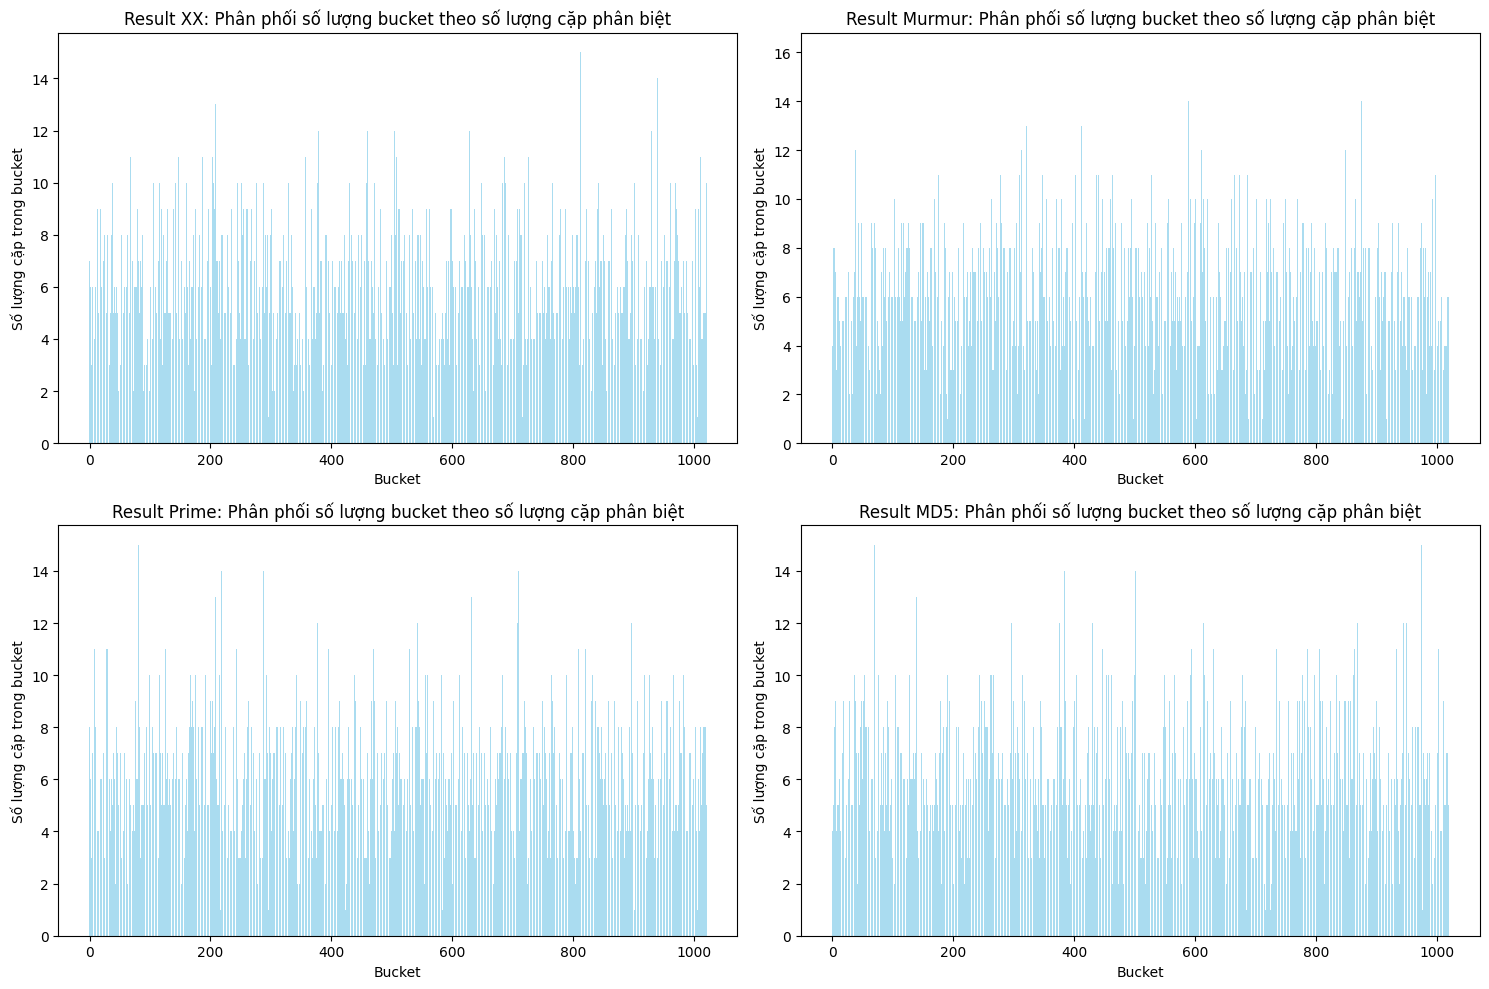

In [66]:
def bar_chart(result_xx, result_murmur, result_prime, result_md5):
    pd_result_xx = convert_to_pandas(result_xx)
    pd_result_murmur = convert_to_pandas(result_murmur)
    pd_result_prime = convert_to_pandas(result_prime)
    pd_result_md5 = convert_to_pandas(result_md5)

    # Tạo 1 figure với 4 subplots (2 hàng x 2 cột)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 2 columns

    # Vẽ biểu đồ cho mỗi result
    axes[0, 0].bar(pd_result_xx['Bucket'], pd_result_xx['distinct_count'], \
                   color='skyblue', alpha=0.7)
    axes[0, 0].set_title("Result XX: Phân phối số lượng bucket theo số lượng cặp phân biệt")
    axes[0, 0].set_xlabel("Bucket")
    axes[0, 0].set_ylabel("Số lượng cặp trong bucket")

    axes[0, 1].bar(pd_result_murmur['Bucket'], pd_result_murmur['distinct_count'], \
                   color='skyblue', alpha=0.7)
    axes[0, 1].set_title("Result Murmur: Phân phối số lượng bucket theo số lượng cặp phân biệt")
    axes[0, 1].set_xlabel("Bucket")
    axes[0, 1].set_ylabel("Số lượng cặp trong bucket")

    axes[1, 0].bar(pd_result_prime['Bucket'], pd_result_prime['distinct_count'], \
                   color='skyblue', alpha=0.7)
    axes[1, 0].set_title("Result Prime: Phân phối số lượng bucket theo số lượng cặp phân biệt")
    axes[1, 0].set_xlabel("Bucket")
    axes[1, 0].set_ylabel("Số lượng cặp trong bucket")

    axes[1, 1].bar(pd_result_md5['Bucket'], pd_result_md5['distinct_count'], \
                   color='skyblue', alpha=0.7)
    axes[1, 1].set_title("Result MD5: Phân phối số lượng bucket theo số lượng cặp phân biệt")
    axes[1, 1].set_xlabel("Bucket")
    axes[1, 1].set_ylabel("Số lượng cặp trong bucket")

    # Tự động điều chỉnh layout để không bị chồng lên nhau
    plt.tight_layout()
    plt.show()

bar_chart(
    result_xx["pairs_hashed_df"],
    result_murmur["pairs_hashed_df"],
    result_prime["pairs_hashed_df"],
    result_md5["pairs_hashed_df"]
)

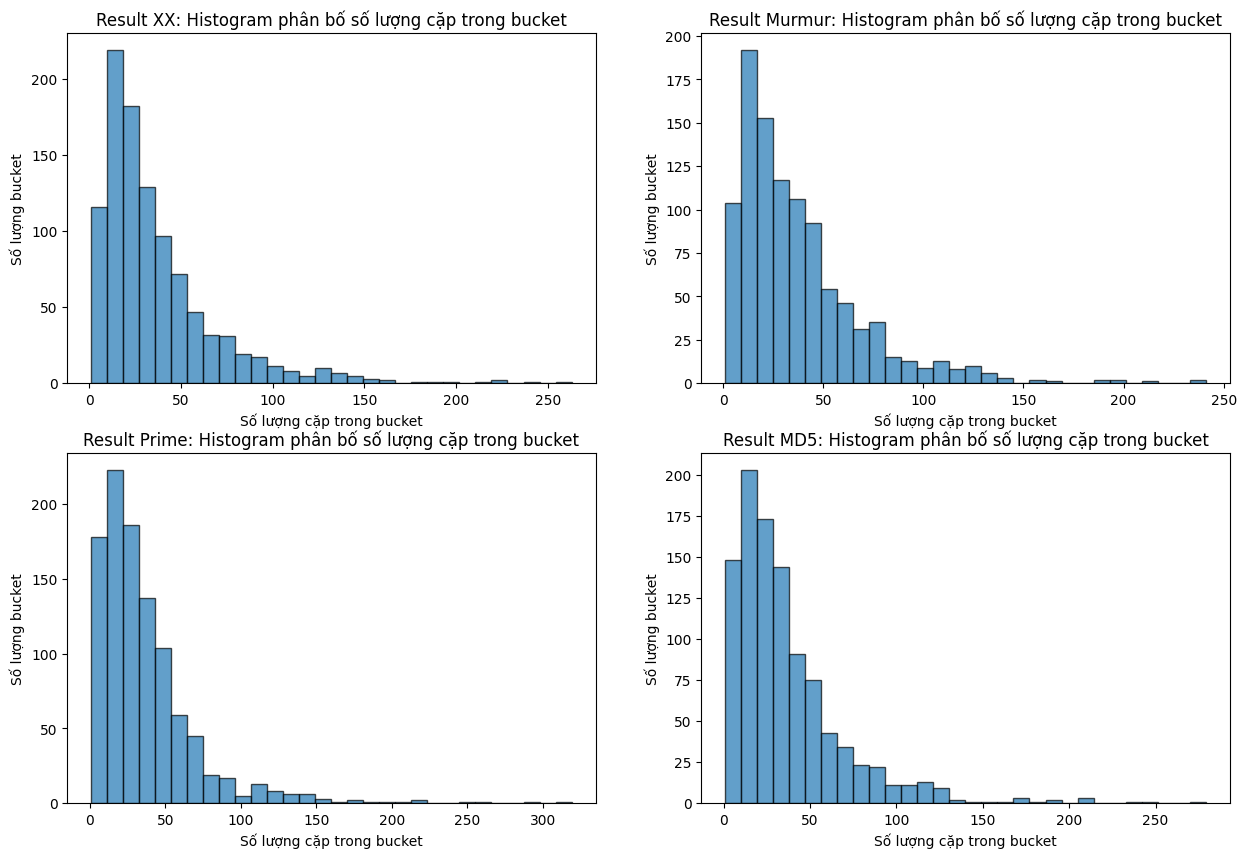

In [67]:
def histogram_count(result_xx, result_murmur, result_prime, result_md5):
    pd_result_xx = convert_to_pandas(result_xx)
    pd_result_murmur = convert_to_pandas(result_murmur)
    pd_result_prime = convert_to_pandas(result_prime)
    pd_result_md5 = convert_to_pandas(result_md5)

    # Tạo 1 figure với 4 subplots (2 hàng x 2 cột) cho histogram
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 2 columns

    # Vẽ histogram cho số lượng cặp trong bucket (count)
    axes[0, 0].hist(pd_result_xx['count'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title("Result XX: Histogram phân bố số lượng cặp trong bucket")
    axes[0, 0].set_xlabel("Số lượng cặp trong bucket")
    axes[0, 0].set_ylabel("Số lượng bucket")

    axes[0, 1].hist(pd_result_murmur['count'], bins=30, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title("Result Murmur: Histogram phân bố số lượng cặp trong bucket")
    axes[0, 1].set_xlabel("Số lượng cặp trong bucket")
    axes[0, 1].set_ylabel("Số lượng bucket")

    axes[1, 0].hist(pd_result_prime['count'], bins=30, edgecolor='black', alpha=0.7)
    axes[1, 0].set_title("Result Prime: Histogram phân bố số lượng cặp trong bucket")
    axes[1, 0].set_xlabel("Số lượng cặp trong bucket")
    axes[1, 0].set_ylabel("Số lượng bucket")

    axes[1, 1].hist(pd_result_md5['count'], bins=30, edgecolor='black', alpha=0.7)
    axes[1, 1].set_title("Result MD5: Histogram phân bố số lượng cặp trong bucket")
    axes[1, 1].set_xlabel("Số lượng cặp trong bucket")
    axes[1, 1].set_ylabel("Số lượng bucket")

histogram_count(
    result_xx["pairs_hashed_df"],
    result_murmur["pairs_hashed_df"],
    result_prime["pairs_hashed_df"],
    result_md5["pairs_hashed_df"]
)

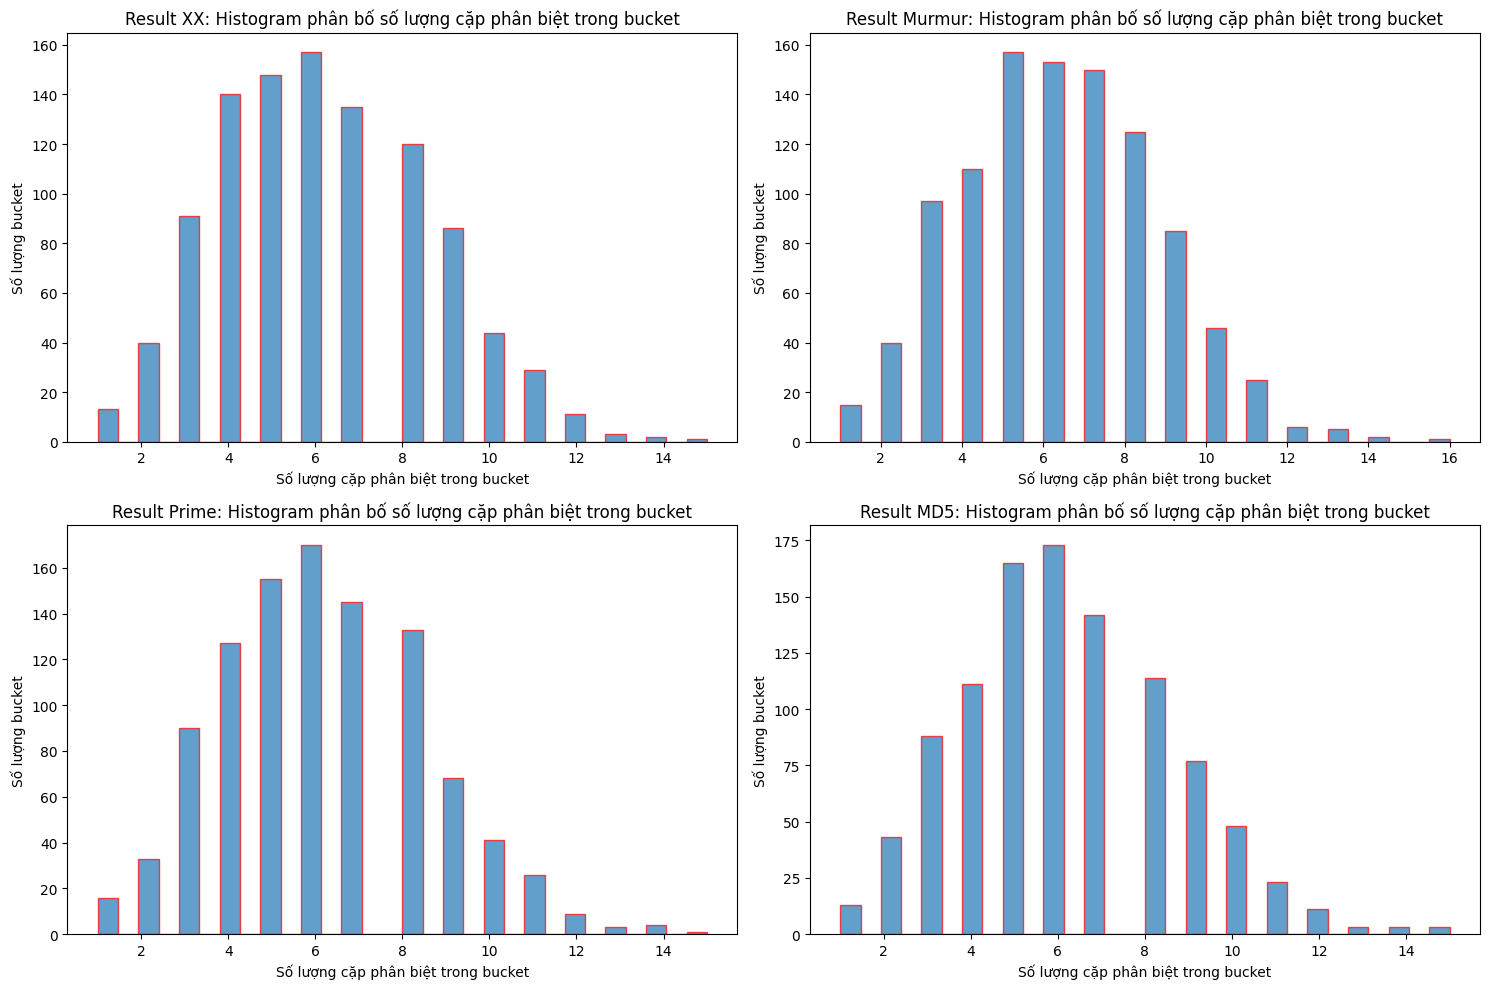

In [68]:
def histogram_distinct_count(result_xx, result_murmur, result_prime, result_md5):
    # Convert các DataFrame PySpark thành DataFrame Pandas
    pd_result_xx = convert_to_pandas(result_xx)
    pd_result_murmur = convert_to_pandas(result_murmur)
    pd_result_prime = convert_to_pandas(result_prime)
    pd_result_md5 = convert_to_pandas(result_md5)

    # Tạo 1 figure với 4 subplots (2 hàng x 2 cột) cho histogram
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 2 columns

    # Vẽ histogram cho số lượng cặp phân biệt trong bucket (distinct_count)
    axes[0, 0].hist(pd_result_xx['distinct_count'], bins=30, edgecolor='red', \
                    alpha=0.7)
    axes[0, 0].set_title("Result XX: Histogram phân bố số lượng cặp phân biệt trong bucket")
    axes[0, 0].set_xlabel("Số lượng cặp phân biệt trong bucket")
    axes[0, 0].set_ylabel("Số lượng bucket")

    axes[0, 1].hist(pd_result_murmur['distinct_count'], bins=30, edgecolor='red', \
                    alpha=0.7)
    axes[0, 1].set_title("Result Murmur: Histogram phân bố số lượng cặp phân biệt trong bucket")
    axes[0, 1].set_xlabel("Số lượng cặp phân biệt trong bucket")
    axes[0, 1].set_ylabel("Số lượng bucket")

    axes[1, 0].hist(pd_result_prime['distinct_count'], bins=30, edgecolor='red', \
                    alpha=0.7)
    axes[1, 0].set_title("Result Prime: Histogram phân bố số lượng cặp phân biệt trong bucket")
    axes[1, 0].set_xlabel("Số lượng cặp phân biệt trong bucket")
    axes[1, 0].set_ylabel("Số lượng bucket")

    axes[1, 1].hist(pd_result_md5['distinct_count'], bins=30, edgecolor='red', \
                    alpha=0.7)
    axes[1, 1].set_title("Result MD5: Histogram phân bố số lượng cặp phân biệt trong bucket")
    axes[1, 1].set_xlabel("Số lượng cặp phân biệt trong bucket")
    axes[1, 1].set_ylabel("Số lượng bucket")

    # Tự động điều chỉnh layout để không bị chồng lên nhau
    plt.tight_layout()
    plt.show()

histogram_distinct_count(
    result_xx["pairs_hashed_df"],
    result_murmur["pairs_hashed_df"],
    result_prime["pairs_hashed_df"],
    result_md5["pairs_hashed_df"]
)